In [28]:
import os, struct
import matplotlib as plt
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros as np
import numpy.linalg as LA

def load_mnist(dataset="training", digits=range(10), path=''):
    
    """
    Adapted from: http://cvxopt.org/applications/svm/index.html?highlight=mnist
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

In [29]:
from pylab import *
from numpy import *
import scipy.sparse as sparse
import scipy.linalg as linalg

images, labels = load_mnist('training', digits=[0,5])

# converting from NX28X28 array into NX784 array
flatimages = list()
for i in images:
    flatimages.append(i.ravel())
X = np.asarray(flatimages)

In [30]:
def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()

Check shape of matrix (11344, 784)
Check shape of label (11344, 1)
Check Mins and Max Values 0 255

Check training vector by plotting image 



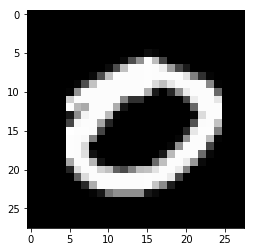

In [31]:
print("Check shape of matrix", X.shape)
print("Check shape of label", labels.shape)
print("Check Mins and Max Values",np.amin(X),np.amax(X))
print("\nCheck training vector by plotting image \n")
plt.imshow(X[20].reshape(28, 28),interpolation='None', cmap=cm.gray)
show()

In [32]:
mu = np.mean(X, axis=0)

In [33]:
#writeExcelData(mu.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 2,2)

In [34]:
Z=X-mu;print(Z)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [35]:
C = np.cov(Z, rowvar=False)
print(C.shape)
print(C)

(784, 784)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [36]:
(eighValues, V)=LA.eigh(C)
print(V.shape)
print(V)

(784, 784)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [37]:
DV = V[:,-2:]#last two column vectors are main eighen vectors

In [38]:
DV

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [39]:
λ=np.flipud(eighValues)
V=np.flipud(V.T)

In [40]:
#writeExcelData(V[0:2,:], "Assignment_3_ Submission_Template_copy.xlsx", "Results", 3,2)

In [41]:
P=np.dot(Z,V.T)
print(P.shape)

(11344, 784)


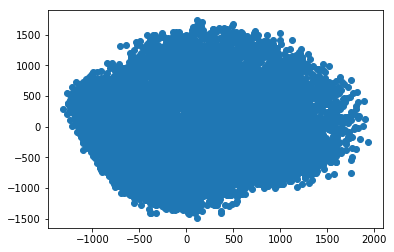

In [42]:
%matplotlib inline
plt.scatter(P[:,0],P[:,1])

In [43]:
Xrec2=(np.dot(P[:,0:2],V[0:2,:]))+mu
Xrec2.shape

(11344, 784)

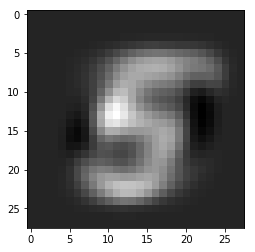

In [45]:
plt.imshow(Xrec2[24].reshape(28, 28),interpolation='None', cmap=cm.gray)
show()

In [46]:
P2D = P[:,0:2]

print(P2D.shape)
print(labels.shape)

(11344, 2)
(11344, 1)


In [47]:
print(np.unique(labels, return_counts=True))

(array([0, 5], dtype=int8), array([5923, 5421]))


In [48]:
import pandas as pd

y = pd.DataFrame(labels, columns=['labels'])
p2d = pd.DataFrame(P2D, columns=['f1','f2'])
#p2dl = pd.merge(y, p2d,left_index=True,right_index=True)
p2dl = pd.concat([y, p2d],axis=1)

Np = p2dl[p2dl['labels'] == 5][['f1','f2']].count()
nn = p2dl[p2dl['labels'] == 0][['f1','f2']].count()
nup = p2dl[p2dl['labels'] == 5][['f1','f2']].mean()
nun = p2dl[p2dl['labels'] == 0][['f1','f2']].mean()
cp = p2dl[p2dl['labels'] == 5][['f1','f2']].cov()
cn = p2dl[p2dl['labels'] == 0][['f1','f2']].cov()

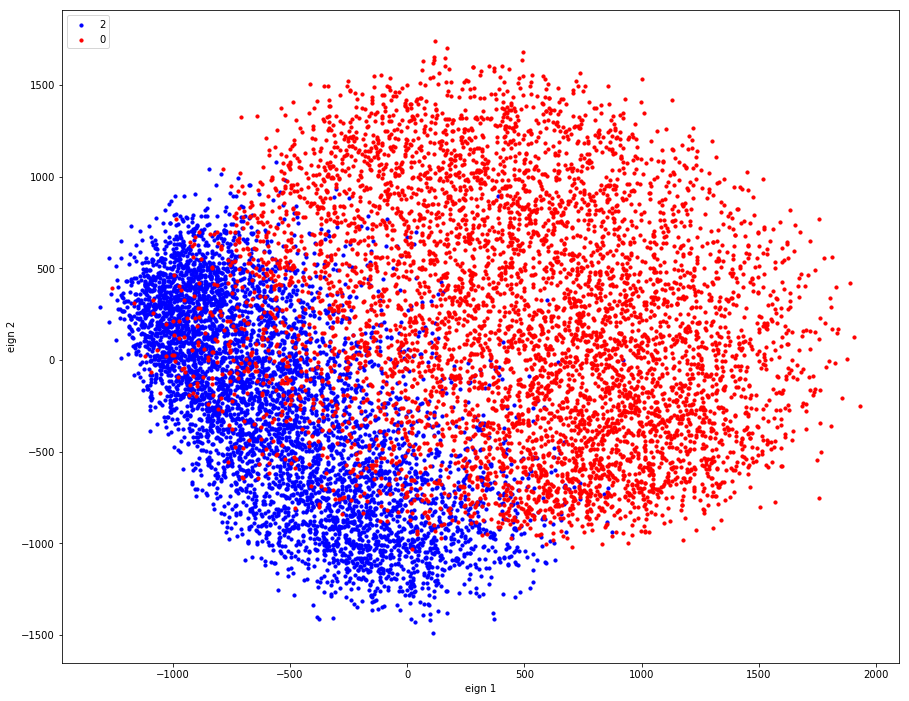

In [49]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(111)

ax1.scatter(p2dl[p2dl['labels'] == 5]['f1'], p2dl[p2dl['labels'] == 5]['f2'], s=10, c='b', marker="o", label='2')
ax1.scatter(p2dl[p2dl['labels'] == 0]['f1'], p2dl[p2dl['labels'] == 0]['f2'], s=10, c='r', marker="o", label='0')
plt.legend(loc='upper left');
plt.ylabel('eign 2')
plt.xlabel('eign 1')
plt.show()

In [50]:
print(Np,'\n\n',nn,'\n\n',nup,'\n\n',nun,'\n\n',cp,'\n\n',cn)

f1    5421
f2    5421
dtype: int64 

 f1    5923
f2    5923
dtype: int64 

 f1   -525.967912
f2   -242.700833
dtype: float64 

 f1    481.389845
f2    222.130882
dtype: float64 

                f1             f2
f1  171963.660263 -143062.146437
f2 -143062.146437  284280.064971 

                f1             f2
f1  358704.283313  -92868.092726
f2  -92868.092726  400027.069013


In [54]:
def histClassifier(X,T, B):
    xmin = X['f1'].min()
    xmax = X['f1'].max()
    ymin = X['f2'].min()
    ymax = X['f2'].max()
    print(xmin, xmax, ymin, ymax)
    HF = np.zeros((B,B)).astype('int32')
    HM = np.zeros((B,B)).astype('int32')
    binindicesX = (np.round((B-1)*(X['f1'] - xmin)/(xmax - xmin))).astype('int32')
    binindicesY = (np.round((B-1)*(X['f2'] - ymin)/(ymax - ymin))).astype('int32')
    for i,b in enumerate(binindicesX):
        if T[i] == 5:
            HF[b][binindicesY[i]]+=1
        else:
            HM[b][binindicesY[i]]+=1
    return (HF,HM)

In [55]:
B = 25
(hp, hn) = histClassifier(p2dl, p2dl['labels'], B)

-1310.11834514 1930.81947098 -1490.38932527 1739.12982473


In [56]:
#writeExcelData(hp, "Assignment_3_ Submission_Template_copy.xlsx", "Results", 20,2)

In [57]:
#writeExcelData(hn, "Assignment_3_ Submission_Template_copy.xlsx", "Results", 46,2)

In [58]:
print(hp.sum(), hn.sum())

5421 5923


In [59]:
xp = X[25]
zp = xp - mu
pp = np.dot(zp,V.T)[0:2]
rp = np.dot(pp, V[0:2])
xrecp = rp + mu

In [60]:
#writeExcelData(xp.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 74,2)
#writeExcelData(zp.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 75,2)
#writeExcelData(rp.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 77,2)
#writeExcelData(xrecp.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 78,2)

In [61]:
xn = X[20]
zn = xn - mu
pn = np.dot(zn,V.T)[0:2]
rn = np.dot(pn, V[0:2])
xrecn = rn + mu

In [62]:
#writeExcelData(xn.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 80,2)
#writeExcelData(zn.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 81,2)
#writeExcelData(rn.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 83,2)
#writeExcelData(xrecn.reshape((1,784)), "Assignment_3_ Submission_Template_copy.xlsx", "Results", 84,2)

In [63]:
print(pp, pn)

[  14.65378941 -354.7873868 ] [ 1162.50962295   412.86447552]


In [64]:
queries = [pp, pn]
def hist_prob(queries, data, HF, HM, B):
    for query in queries:
        heightBin = (np.round((B-1)*(query[0] - data['f1'].min())/(data['f1'].max()- data['f1'].min()))).astype('int32')
        headSpanBin = (np.round((B-1)*(query[1] - data['f2'].min())/(data['f2'].max() - data['f2'].min()))).astype('int32')
        print(" ",HF[heightBin][headSpanBin]/(HF[heightBin][headSpanBin] + HM[heightBin][headSpanBin]))
hist_prob(queries, p2dl, hp, hn, B)

  0.466666666667
  0.0


In [29]:
cp.as_matrix()

array([[ 104812.33789505,   63912.13500627],
       [  63912.13500627,  215391.61263587]])

In [30]:
from scipy.stats import multivariate_normal
pdfp = multivariate_normal(mean = nup.as_matrix(), cov = cp.as_matrix())
pdfn = multivariate_normal(mean = nun.as_matrix(), cov = cn.as_matrix())

In [31]:
Np.as_matrix()

array([5958, 5958])

In [32]:
queries = [pp, pn]
def baeyes_prob(queries, pdfp, pdfn, Np, Nn):
    for query in queries:
        print(Np*pdfp.pdf(query)/(Np*pdfp.pdf(query)+Nn*pdfn.pdf(query)))
        #print(Nn*pdfn.pdf(query)/(Np*pdfp.pdf(query)+Nn*pdfn.pdf(query)))
baeyes_prob(queries, pdfp, pdfn, Np.as_matrix()[0], nn.as_matrix()[0])

0.973028469657
3.28617723122e-14


In [35]:
P2D.shape
labels.shape

(11881, 1)

In [136]:
def hist_accuracy(queries, data, HF, HM, B, target):
    correct = 0
    for index, query in enumerate(queries):
        heightBin = (np.round((B-1)*(query[0] - data['f1'].min())/(data['f1'].max()- data['f1'].min()))).astype('int32')
        headSpanBin = (np.round((B-1)*(query[1] - data['f2'].min())/(data['f2'].max() - data['f2'].min()))).astype('int32')
        posProb = HF[heightBin][headSpanBin]/(HF[heightBin][headSpanBin] + HM[heightBin][headSpanBin])
        prediction = 2 if posProb >= 0.5 else 0 # same with negProb > 0.5
        correct = correct+1 if prediction == target[index] else correct
    return correct/float(len(queries))
print(hist_accuracy(P2D, p2dl, hp, hn, B, labels))

11307
0.9516875683864995


In [135]:
print(2.2 * 3.0 > 6.6)
print(3.3 * 2.0 < 6.6)

True
False


In [103]:
def baeyes_accuracy(queries, pdfp, pdfn, Np, Nn, target):
    correct = 0
    for index, query in enumerate(queries):
        negProb = (Nn*pdfn.pdf(query)/(Np*pdfp.pdf(query)+Nn*pdfn.pdf(query)))
        prediction = 0 if negProb > 0.5 else 2 # same with negProb > 0.5
        correct = correct+1 if prediction == target[index] else correct
    return correct/float(len(queries))
print(baeyes_accuracy(P2D, pdfp, pdfn, Np.as_matrix()[0], nn.as_matrix()[0], labels))

0.9501725443986196


0.9501725443986196
